In [1]:
# General imports
import numpy as np
import qiskit
from qiskit.quantum_info import SparsePauliOp
from qiskit.quantum_info import DensityMatrix, partial_trace
# SciPy minimizer routine
from scipy.optimize import minimize

# Plotting functions
import matplotlib.pyplot as plt

In [2]:
# [Reference]: https://docs.quantum.ibm.com/guides/build-noise-models
# https://docs.quantum.ibm.com/guides/simulate-with-qiskit-aer

from qiskit_aer import AerSimulator

from qiskit_aer.primitives import SamplerV2 as Sampler
#from qiskit_ibm_runtime import SamplerV2 as Sampler
# from qiskit.primitives import StatevectorSampler
# sampler = StatevectorSampler()
sampler = Sampler()


from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_aer.noise import (NoiseModel,QuantumError,ReadoutError,depolarizing_error,pauli_error,thermal_relaxation_error)
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
# YOUR_API_TOKEN = "a44932650c6324c729fbd156e2808cff2dc96cc78fdaf3058a5e3583edfadad4acf73471140788f0efa7ed71a98f1e13069af52fe115e4e0e2bb868ab0be5d70"
# QiskitRuntimeService.save_account(channel="ibm_quantum", token= YOUR_API_TOKEN, overwrite = True)
# service = QiskitRuntimeService()
# backend = service.backend("ibm_brisbane")
# noise_model = NoiseModel.from_backend(backend)

In [3]:
from scipy.sparse import csr_matrix
from scipy.sparse import csr_matrix, kron
from numpy import trace

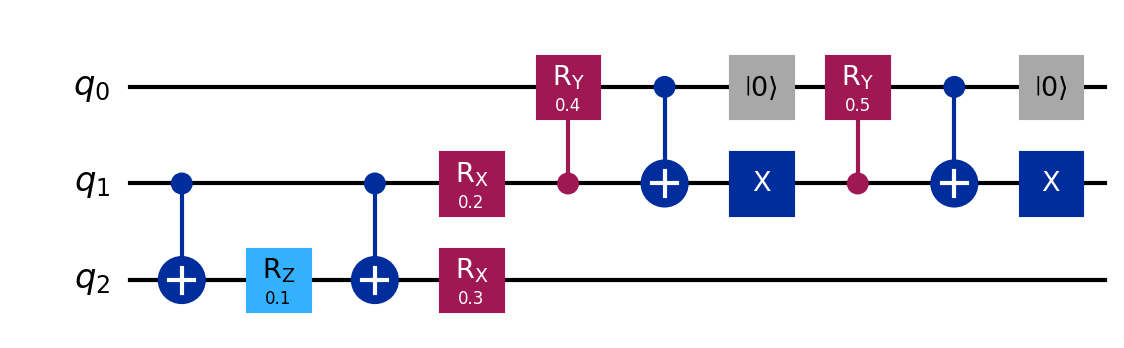

In [26]:
# VQA circuit.
from qiskit import QuantumCircuit, transpile

I = np.array([[1,0],[0,1]])
sigma_x = np.array([[0,1],[1,0]])
sigma_y = np.array([[0,-1j],[1j,0]])
sigma_z = np.array([[1,0],[0,-1]])

"""
The TFIM for L = 2 is given by: H = J * (Z_1 * Z_2) + h * (X_1 + X_2). We will consider
the two jump operators: L_1 = sqrt(g_1) * (X_1 - i * Y_1} and L_2 = sqrt(g_2) * (X_2 - i Y_2).

"""

# The variational circuit is just the trotter circuit for the TFIM.
n_qubits = 2
def anstaz_circuit(angles_lst, number_of_layers):  

     number_of_angles_per_layer = 4

     if len(angles_lst*number_of_angles_per_layer) % number_of_layers != 0:
         raise ValueError("The number of angles should be divisible by the number of layers.")
     else:
           anstaz_circuit = QuantumCircuit(n_qubits+1)
           for i in range(number_of_layers):
               # Hamiltonian part.
               anstaz_circuit.cx(1,2)
               anstaz_circuit.rz(angles_lst[i][0], 2)
               anstaz_circuit.cx(1,2)
               anstaz_circuit.rx(angles_lst[i][1], 1)
               anstaz_circuit.rx(angles_lst[i][2], 2)
               # Jump operator part.
               anstaz_circuit.cry(angles_lst[i][3], 1, 0)
               anstaz_circuit.cx(0,1)
               anstaz_circuit.reset(0)
               anstaz_circuit.x(1)
               anstaz_circuit.cry(angles_lst[i][4], 1, 0)
               anstaz_circuit.cx(0,1)
               anstaz_circuit.x(1)
               anstaz_circuit.reset(0)
     return anstaz_circuit      

anstaz_circuit([[0.1, 0.2, 0.3, 0.4, 0.5]], 1).draw("mpl", scale = 1.5)     

In [75]:
J = 1.0
h = 1.0
gamma_1 = 1
gamma_2 = 0.5

def lindblad_equation(rho):
     """
     The Lindblad equation for the density matrix rho is given by: d rho / dt = -i [H, rho] + sum_i (L_i rho L_i^dagger - 0.5 {L_i^dagger L_i, rho}).
     """
     # Define the Hamiltonian.
     H = 1j * J * (np.kron(sigma_z, sigma_z) + h * (np.kron(sigma_x, I) + np.kron(I, sigma_x)))
     # Define the jump operators.
     L_1 = np.sqrt(gamma_1) * (np.kron(sigma_x, I) - 1j * np.kron(sigma_y, I))
     L_2 = np.sqrt(gamma_2) * (np.kron(I, sigma_x) - 1j * np.kron(I, sigma_y))
     # Define the Lindblad equation.
     d_rho_dt = -1j * (np.dot(H, rho) - np.dot(rho, H)) + np.dot(L_1, np.dot(rho, np.conj(L_1).T)) + np.dot(L_2, np.dot(rho, np.conj(L_2).T)) - 0.5 * (np.dot(np.conj(L_1).T, np.dot(L_1, rho)) + np.dot(np.conj(L_2).T, np.dot(L_2, rho)))
     return d_rho_dt     

In [30]:
def return_density_matrix(quantum_circuit):

     quantum_circuit.save_density_matrix()  # Save the density matrix

     # Step 2: Simulate the circuit
     simulator = AerSimulator()  # Aer simulator supports reset gates
     quantum_circuit = transpile(quantum_circuit, simulator)
     result = simulator.run(quantum_circuit).result()
     # Step 3: Extract the density matrix
     rho_full = DensityMatrix(result.data()["density_matrix"])

     # Step 4: Compute the reduced density matrix for the second qubit
     rho_1 = partial_trace(rho_full, [0])  # Trace out qubit 0
     rho_1_matrix = rho_1.data

     return rho_1_matrix

In [51]:
def cost_function(rho):
     L_rho = lindblad_equation(rho)
     return np.real(np.trace(L_rho.conj().T@L_rho))

# Variational algorithm for cost function optimization

In [ ]:
tolerance_for_convergence = 1.e-2
# Random initial angle parameters.
theta_1 = np.random.uniform(0, 2*np.pi)
theta_2 = np.random.uniform(0, 2*np.pi)
theta_3 = np.random.uniform(0, 2*np.pi)
theta_4 = np.random.uniform(0, 2*np.pi)
theta_5 = np.random.uniform(0, 2*np.pi)

theta_1_values = [theta_1]
theta_2_values = [theta_2]
theta_3_values = [theta_3]
theta_4_values = [theta_4]
theta_5_values = [theta_5]

initial_learning_rate = 10
number_of_layers = 1
number_of_iterations = 0
max_iterations = 100

best_cost = float("inf")
best_theta_1, best_theta_2, best_theta_3, best_theta_4, best_theta_5 = theta_1, theta_2, theta_3, theta_4, theta_5
best_iteration = 0

cost_function_values_lst = []

while number_of_iterations <= max_iterations:

    vqa_circuit = anstaz_circuit([[theta_1, theta_2, theta_3, theta_4, theta_5]], number_of_layers)
    rho = return_density_matrix(vqa_circuit)
    cost_value = cost_function(rho)
    cost_function_values_lst.append(cost_value)

    if cost_value < best_cost:
        best_cost = cost_value
        best_theta_1, best_theta_2, best_theta_3, best_theta_4, best_theta_5 = theta_1, theta_2, theta_3, theta_4, theta_5
        best_iteration = number_of_iterations
    
    if cost_value <= tolerance_for_convergence:
        print("\n[CONVERGED] Cost function is less than the tolerance value.\n")
        print("Cost function =", cost_value)
        print("Optimized parameters =", theta_x, theta_y, theta_z, phi)
        break

    # Decaying learning rate.
    learning_rate = initial_learning_rate / (1 + number_of_iterations)

    gradients = []
    for i in range(5):
        theta_plus = [theta_1, theta_2, theta_3, theta_4, theta_5]
        theta_minus = [theta_1, theta_2, theta_3, theta_4, theta_5]
        theta_plus[i] += np.pi / 2
        theta_minus[i] -= np.pi / 2
        
        vqa_circuit_plus = anstaz_circuit([theta_plus], number_of_layers)
        vqa_circuit_minus = anstaz_circuit([theta_minus], number_of_layers)
        
        gradient = (cost_function(return_density_matrix(vqa_circuit_plus)) - cost_function(return_density_matrix(vqa_circuit_minus))) / 2
        gradients.append(gradient)
     
    # Parameter update.
    theta_1 -= learning_rate * gradients[0]
    theta_2 -= learning_rate * gradients[1]
    theta_3 -= learning_rate * gradients[2]
    theta_4 -= learning_rate * gradients[3]
    theta_5 -= learning_rate * gradients[4]

    theta_1_values.append(theta_1)
    theta_2_values.append(theta_2)
    theta_3_values.append(theta_3)
    theta_4_values.append(theta_4)
    theta_5_values.append(theta_5)

    number_of_iterations += 1
    print("Cost function =", cost_value)
    #print("Parameters =", theta_1, theta_2, theta_3, theta_4, theta_5)
    print("Number of iterations =", number_of_iterations)
    print("Learning rate =", learning_rate)

    if number_of_iterations == max_iterations:
        print("\n[NOT CONVERGED] Maximum number of iterations reached.\n")
        print("Best cost function =", best_cost)
        print("Best parameters =", best_theta_1, best_theta_2, best_theta_3, best_theta_4, best_theta_5)
        print("Best iteration =", best_iteration)
        break

Cost function = 7.007832783876222
Number of iterations = 1
Learning rate = 10.0
Cost function = 5.429486118415435
Number of iterations = 2
Learning rate = 5.0
Cost function = 23.168062691592233
Number of iterations = 3
Learning rate = 3.3333333333333335
Cost function = 20.983499837242782
Number of iterations = 4
Learning rate = 2.5
Cost function = 19.250083757711835
Number of iterations = 5
Learning rate = 2.0
Cost function = 5.592374206641531
Number of iterations = 6
Learning rate = 1.6666666666666667
Cost function = 9.174684908583941
Number of iterations = 7
Learning rate = 1.4285714285714286
Cost function = 10.276635388149343
Number of iterations = 8
Learning rate = 1.25
Cost function = 22.017425432152574
Number of iterations = 9
Learning rate = 1.1111111111111112
Cost function = 15.206561685956437
Number of iterations = 10
Learning rate = 1.0
Cost function = 10.951988650516377
Number of iterations = 11
Learning rate = 0.9090909090909091
Cost function = 5.40544790514951
Number of it

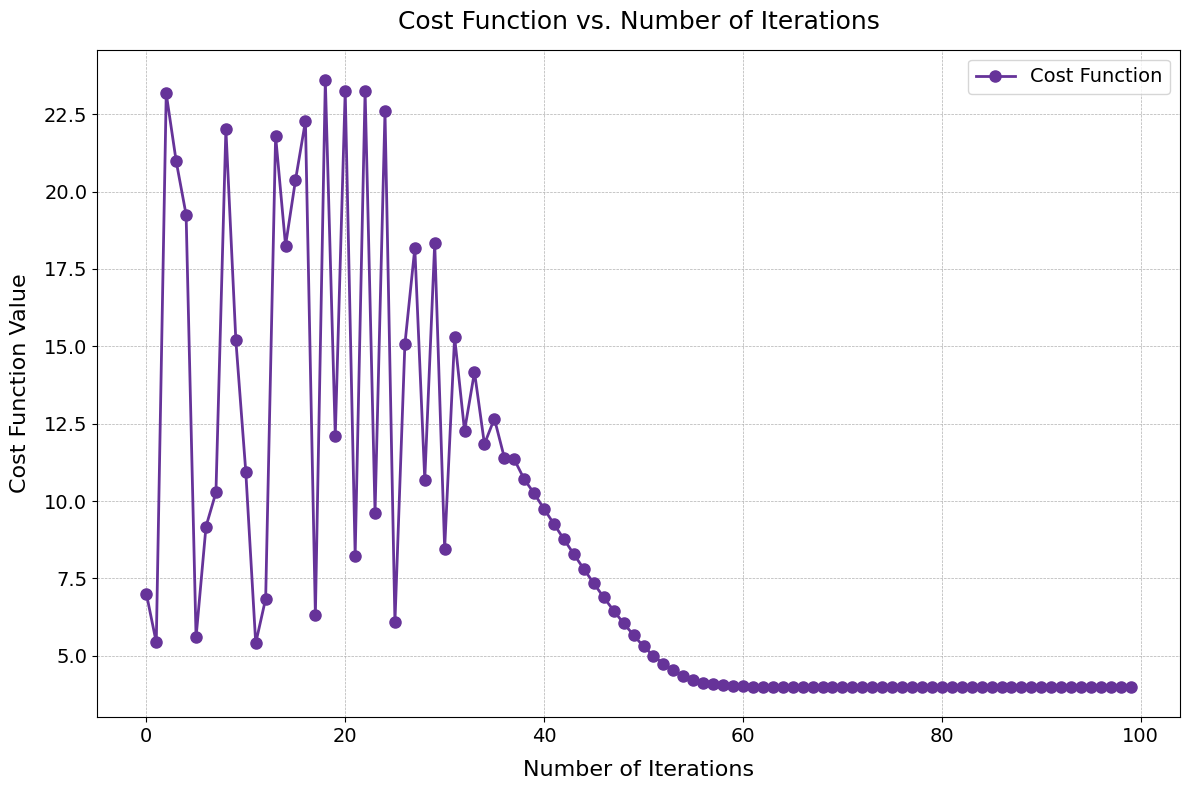

In [83]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(cost_function_values_lst)), cost_function_values_lst, marker='o', linestyle='-', color="rebeccapurple", linewidth=2, markersize=8, label='Cost Function')

plt.xlabel('Number of Iterations', fontsize=16, labelpad=10)
plt.ylabel('Cost Function Value', fontsize=16, labelpad=10)
plt.title('Cost Function vs. Number of Iterations', fontsize=18, pad=15)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.tight_layout()
plt.show()

# Plot of the cost landscape

In [64]:
theta_4_lst = np.linspace(0, 2*np.pi, 50)
theta_2_lst = np.linspace(0, 2*np.pi, 50)
theta_1_lst = [0.1] #np.linspace(0, 2*np.pi, 10)
theta_3_lst = [0.2] #np.linspace(0, 2*np.pi, 10)
theta_5_lst = [0.3] #np.linspace(0, 2*np.pi, 10)

cost_function_values_lst = []

for theta_1 in theta_1_lst:
    for theta_2 in theta_2_lst:
        for theta_3 in theta_3_lst:
            for theta_4 in theta_4_lst:
                for theta_5 in theta_5_lst:
                    cost_function_values_lst.append(cost_function(return_density_matrix(anstaz_circuit([[theta_1, theta_2, theta_3, theta_4, theta_5]], 1))))

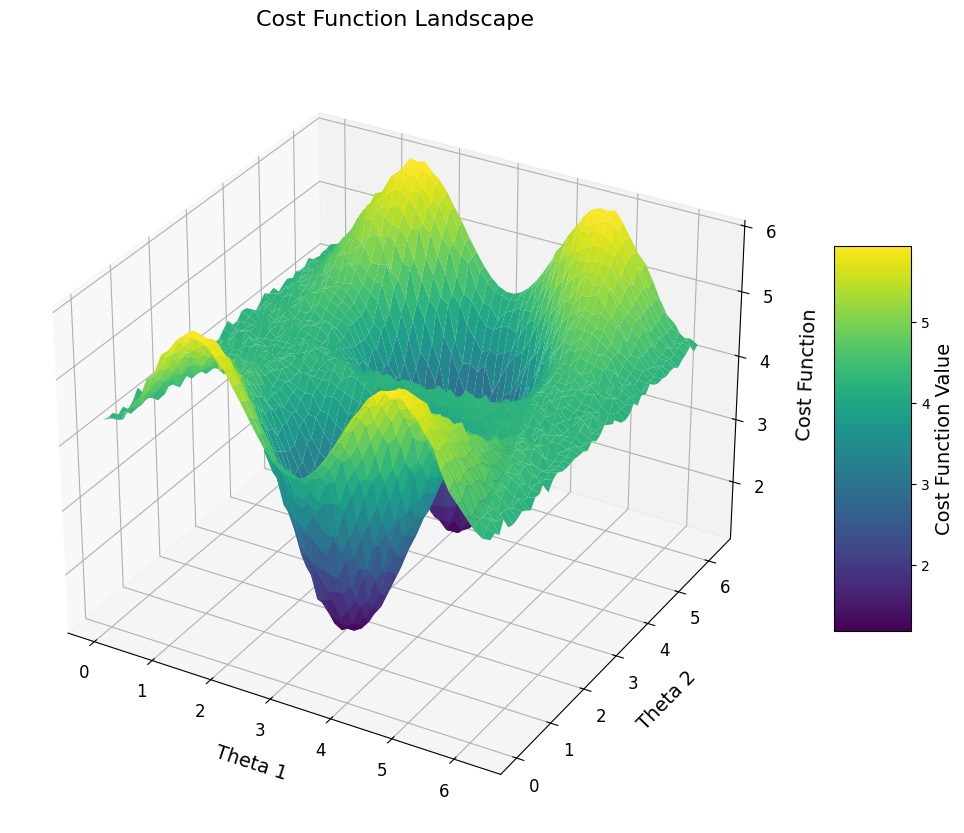

In [65]:
from mpl_toolkits.mplot3d import Axes3D

angle_parameter_1 = theta_4_lst
angle_parameter_2 = theta_2_lst
# Reshape the cost function values to match the shape of theta_1_lst and theta_2_lst
cost_function_values = np.array(cost_function_values_lst).reshape(len(angle_parameter_1), len(angle_parameter_2))

# Create a meshgrid for theta_1 and theta_2
theta_1_grid, theta_2_grid = np.meshgrid(angle_parameter_1, angle_parameter_2)

# Plot the 3D surface
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(theta_1_grid, theta_2_grid, cost_function_values.T, cmap='viridis', edgecolor='none')

# Add a color bar which maps values to colors
cbar = fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
cbar.set_label('Cost Function Value', fontsize=14)

# Set labels with larger font sizes
ax.set_xlabel('Theta 1', fontsize=14, labelpad=10)
ax.set_ylabel('Theta 2', fontsize=14, labelpad=10)
ax.set_zlabel('Cost Function', fontsize=14, labelpad=10)

# Set tick parameters for better readability
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='z', which='major', labelsize=12)

# Set title
ax.set_title('Cost Function Landscape', fontsize=16, pad=20)

plt.show()